In [1]:
# Cell 1: Imports
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Cell 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

os.makedirs('data/processed', exist_ok=True)

# Copy data from Drive
!cp /content/drive/MyDrive/stat362_data/*.npy data/processed/
!cp /content/drive/MyDrive/stat362_data/*.pkl data/processed/


Mounted at /content/drive


In [3]:
# Cell 3: Load Data (smaller sample)
X_train_text_full = np.load('data/processed/X_train_text.npy', allow_pickle=True)
X_val_text = np.load('data/processed/X_val_text.npy', allow_pickle=True)
X_test_text = np.load('data/processed/X_test_text.npy', allow_pickle=True)

y_train_full = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Sample 20,000 for training (DistilBERT needs more RAM)
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_text_full), 20000, replace=False)
X_train_text = X_train_text_full[sample_idx]
y_train = y_train_full[sample_idx]

# Free memory
del X_train_text_full, y_train_full

print(f"Train: {len(X_train_text)}, Val: {len(X_val_text)}, Test: {len(X_test_text)}")

Train: 20000, Val: 10000, Test: 10000


In [4]:
# Cell 3b: Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
import torch

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f"Class weights: Neg={class_weights[0]:.2f}, Neu={class_weights[1]:.2f}, Pos={class_weights[2]:.2f}")

Class weights: Neg=2.28, Neu=3.95, Pos=0.43


In [5]:
# Cell 4: Install transformers
!pip install transformers datasets -q

In [6]:
# Cell 5: Load DistilBERT
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print(f"GPU available: {torch.cuda.is_available()}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

GPU available: True


In [7]:
# Cell 6: Prepare Datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = Dataset.from_dict({'text': X_train_text.tolist(), 'label': y_train.tolist()})
val_dataset = Dataset.from_dict({'text': X_val_text.tolist(), 'label': y_val.tolist()})
test_dataset = Dataset.from_dict({'text': X_test_text.tolist(), 'label': y_test.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
# Cell 7: Load Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

print(f"Parameters: {model.num_parameters():,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameters: 66,955,779


In [9]:
# Cell 7b: Custom Weighted Trainer
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:
# Cell 8: Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to='none'
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [11]:
# Cell 9: Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.707000,0.675091,0.840100,0.675941
2,0.515700,0.691304,0.839700,0.690401
3,0.441900,0.836943,0.851100,0.696294


TrainOutput(global_step=3750, training_loss=0.5664894058227539, metrics={'train_runtime': 820.7732, 'train_samples_per_second': 73.102, 'train_steps_per_second': 4.569, 'total_flos': 1987046415360000.0, 'train_loss': 0.5664894058227539, 'epoch': 3.0})

In [12]:
# Cell 10: Evaluate
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)

test_acc = accuracy_score(y_test, y_pred)
f1_distilbert = f1_score(y_test, y_pred, average='macro')

print(f"DistilBERT Test Accuracy: {test_acc*100:.2f}%")
print(f"DistilBERT Macro F1: {f1_distilbert:.4f}\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

DistilBERT Test Accuracy: 83.65%
DistilBERT Macro F1: 0.6669

              precision    recall  f1-score   support

    Negative       0.70      0.74      0.72      1463
     Neutral       0.30      0.43      0.35       829
    Positive       0.95      0.90      0.92      7708

    accuracy                           0.84     10000
   macro avg       0.65      0.69      0.67     10000
weighted avg       0.86      0.84      0.85     10000



In [18]:
# Simple threshold adjustment
import torch.nn.functional as F

probs = F.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Boost neutral by 1.5x
probs[:, 1] *= 1.3

y_pred_boosted = probs.argmax(axis=1)

print(f"Accuracy: {(y_pred_boosted == y_test).mean()*100:.2f}%")
print(f"Macro F1: {f1_score(y_test, y_pred_boosted, average='macro'):.4f}")
print(classification_report(y_test, y_pred_boosted, target_names=['Negative', 'Neutral', 'Positive']))

Accuracy: 83.14%
Macro F1: 0.6714
              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1463
     Neutral       0.30      0.50      0.37       829
    Positive       0.96      0.89      0.92      7708

    accuracy                           0.83     10000
   macro avg       0.66      0.70      0.67     10000
weighted avg       0.87      0.83      0.85     10000



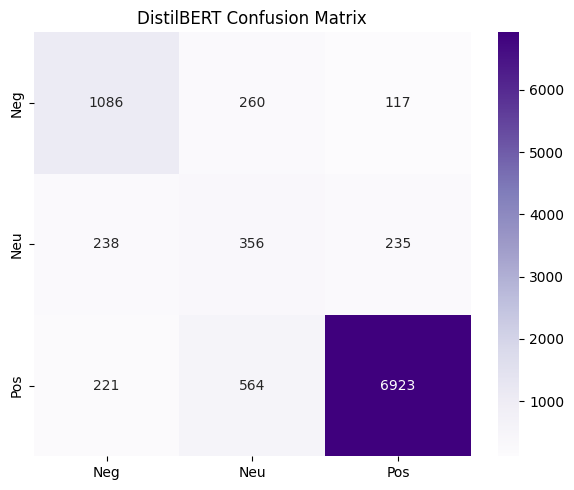

In [19]:
# Cell 11: Confusion Matrix
Path('results/figures').mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Neg', 'Neu', 'Pos'],
            yticklabels=['Neg', 'Neu', 'Pos'], ax=ax)
ax.set_title('DistilBERT Confusion Matrix')
plt.tight_layout()
plt.savefig('results/figures/distilbert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Cell 12: Save Results
Path('results/metrics').mkdir(parents=True, exist_ok=True)

distilbert_results = {
    'model': 'DistilBERT',
    'test_accuracy': float(test_acc),
    'macro_f1': float(f1_distilbert),
    'parameters': int(model.num_parameters())
}

with open('results/metrics/distilbert_results.json', 'w') as f:
    json.dump(distilbert_results, f, indent=2)

# Save model
trainer.save_model('models/distilbert_best')

# Copy to Drive
!cp -r results/ /content/drive/MyDrive/stat362_data/
!cp -r models/distilbert_best /content/drive/MyDrive/stat362_data/